In [7]:
# Please install openpyxl and odfpy from pip or anaconda in order to import the inout data files
import sys
# !{sys.executable} -m pip install openpyxl
# !{sys.executable} -m pip install odfpy

# Import libraries and set plot styles
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Remove warning for chained assignment
pd.options.mode.chained_assignment = None  # default='warn'

# Show plots inline
%matplotlib inline

# Set plot style
# plot.style.available
plt.style.use('fivethirtyeight')

In [8]:
# Read in and preview data
df = pd.read_csv('/Users/FM/Public/HDS/Summer Project/wastewater_r_estimation/Data/agg_data_inner_11_cis_mar22.csv',
                 parse_dates=['date'],
                 dayfirst=True)
df1 = pd.read_excel('/Users/FM/Public/HDS/Summer Project/wastewater_r_estimation/Data/Region Mapping.xlsx')
df2 = pd.read_excel('/Users/FM/Public/HDS/Summer Project/R_and_growth_rate_time_series_for_publication_v1.0.ods',
                    sheet_name=2,
                    engine='odf',
                    header=[7,8], #Two rows of header
                    na_values='.'
                    )

# Check for missing values
df.isnull().sum()

# Select header titles and data range
df1.columns = df1.iloc[2]
region_map = df1.iloc[3:, :]
r_val = df2.iloc[:, 1:]

# Merge 2 header rows
r_val.columns = ['_'.join(header).upper() for header in r_val.columns]
r_val.drop(['UK_UPPER BOUND', 'UK_LOWER BOUND'], axis=1)

# Remove missing values
region_map.dropna()
r_val = r_val.dropna()

# Rename specific columns for joining
df.rename(columns={'cis20cd': 'CIS20CD'}, inplace=True)
df.rename(columns={'grab_compo_boo': 'compo_frac'}, inplace=True)
region_map.rename(columns={'Geography Code': 'CIS20CD'}, inplace=True)
r_val.rename(columns={'DATE_UNNAMED: 1_LEVEL_1': 'date'}, inplace=True)

### Copied from UKHSA code ###
# Variable labels that are not changed
variable_labels = {
    'sars_cov2_gc_l_mean': 'SARS-CoV-2 concentration',
    'sample_ph_pre_ansis':'sample pH',
    'ammonia_mg_l':'ammonia concentration',
    #'control_gc_l_mean':'control volume',
    'ophosph_mg_l':'phosphate concentration',
    'suspended_solids_mg_l':'suspended solids',
    'sars_below_loq':'below LOQ',
    'sars_below_lod':'below LOD',
    'compo_frac':'composites fraction',
    'reception_delay':'reception delay',
    'catch_cis_population':'covered population',
    'catch_in_cis_prop':'subregion population fraction',
    "catchment_population_ons_mid_2019": "catchment population",
    "catchment_area": 'catchment area'
}

In [9]:
df['date'] = pd.to_datetime(df['date'])
r_val['date'] = pd.to_datetime(r_val['date'],
                               format = '%Y-%m-%d %H:%M:%S',
                               errors='coerce')

# df.head()
# region_map.head()
# r_val.head()

# Check R values shortly before study period (for out-of-range interpolation)
# r_val[r_val['date'].between('2020-08-20','2020-09-07')]

### Generate average r values for each region

In [10]:
# r_val['UK_AVERAGE'] = r_val[['UK_LOWER BOUND', 'UK_UPPER BOUND']].mean(axis=1)
r_val['ENGLAND_AVERAGE'] = r_val[['ENGLAND_LOWER BOUND', 'ENGLAND_UPPER BOUND']].mean(axis=1)
r_val['EAST OF ENGLAND_AVERAGE'] = r_val[['EAST OF ENGLAND_LOWER BOUND', 'EAST OF ENGLAND_UPPER BOUND']].mean(axis=1)
r_val['LONDON_AVERAGE'] = r_val[['LONDON_LOWER BOUND', 'LONDON_UPPER BOUND']].mean(axis=1)
r_val['MIDLANDS_AVERAGE'] = r_val[['MIDLANDS_LOWER BOUND', 'MIDLANDS_UPPER BOUND']].mean(axis=1)
r_val['NORTH EAST AND YORKSHIRE_AVERAGE'] = r_val[['NORTH EAST AND YORKSHIRE_LOWER BOUND', 'NORTH EAST AND YORKSHIRE_UPPER BOUND']].mean(axis=1)
r_val['NORTH WEST_AVERAGE'] = r_val[['NORTH WEST_LOWER BOUND', 'NORTH WEST_UPPER BOUND']].mean(axis=1)
r_val['SOUTH EAST_AVERAGE'] = r_val[['SOUTH EAST_LOWER BOUND', 'SOUTH EAST_UPPER BOUND']].mean(axis=1)
r_val['SOUTH WEST_AVERAGE'] = r_val[['SOUTH WEST_LOWER BOUND', 'SOUTH WEST_UPPER BOUND']].mean(axis=1)

### Linkage

In [31]:
# Match region to codes in wastewater data
df3 = pd.merge(df, region_map[['CIS20CD', 'Country', 'Region']], on='CIS20CD', how='left')

# Weighted average
grouped = df3.groupby(['Region', 'date'])

def wavg(group):
    d = group['sars_cov2_gc_l_mean']
    w = group['catchment_population_ons_mid_2019']
    return (d * w).sum() / w.sum()

df4 = grouped.apply(wavg)
df4 = df4.reset_index()
df4.rename(columns={0: 'weighted_avg_sars_cov2'}, inplace=True) # rename weighted average column
df3.Region.nunique()
df4.head()

,Region,date,weighted_avg_sars_cov2
0,East Midlands,2020-09-04,4059.005490
1,East Midlands,2020-09-06,49356.564046
2,East Midlands,2020-09-07,2122.918500
3,East Midlands,2020-09-09,14980.968398
4,East Midlands,2020-09-11,19439.225934


In [41]:
# Match with R values
model_dataset = pd.merge(df4, r_val, on='date', how='left')

# Merge with all variables
all_var_dataset = pd.merge(df4, df, on='date', how='left').dropna()
all_var_dataset.to_csv("all_var_dataset.csv")

In [43]:
# # Dimension of dataframe
# model_dataset.shape
#
# # Number of unique sites
# model_dataset.Region.nunique()
#
# # Date range
# print('Study period from', model_dataset.date.min(), 'to', model_dataset.date.max())

# Get total population of each region
# Changes over time
population_sum = grouped['catchment_population_ons_mid_2019'].sum()
population_sum.to_csv('Population Over Time.csv')
list(model_dataset.columns)

['Region',
 'date',
 'weighted_avg_sars_cov2',
 'UK_LOWER BOUND',
 'UK_UPPER BOUND',
 'ENGLAND_LOWER BOUND',
 'ENGLAND_UPPER BOUND',
 'EAST OF ENGLAND_LOWER BOUND',
 'EAST OF ENGLAND_UPPER BOUND',
 'LONDON_LOWER BOUND',
 'LONDON_UPPER BOUND',
 'MIDLANDS_LOWER BOUND',
 'MIDLANDS_UPPER BOUND',
 'NORTH EAST AND YORKSHIRE_LOWER BOUND',
 'NORTH EAST AND YORKSHIRE_UPPER BOUND',
 'NORTH WEST_LOWER BOUND',
 'NORTH WEST_UPPER BOUND',
 'SOUTH EAST_LOWER BOUND',
 'SOUTH EAST_UPPER BOUND',
 'SOUTH WEST_LOWER BOUND',
 'SOUTH WEST_UPPER BOUND',
 'ENGLAND_AVERAGE',
 'EAST OF ENGLAND_AVERAGE',
 'LONDON_AVERAGE',
 'MIDLANDS_AVERAGE',
 'NORTH EAST AND YORKSHIRE_AVERAGE',
 'NORTH WEST_AVERAGE',
 'SOUTH EAST_AVERAGE',
 'SOUTH WEST_AVERAGE']

#### Subset of South West region only

In [34]:
subset = model_dataset[['date', 'weighted_avg_sars_cov2', 'Region', 'SOUTH WEST_LOWER BOUND', 'SOUTH WEST_UPPER BOUND', 'SOUTH WEST_AVERAGE']]
subset = subset.loc[(subset['Region'] == 'South West'),:]

#### Perform interpolation into daily data

In [35]:
# Set index as date to perform interpolation
subset.index = subset['date']
# del subset['date']

# Linear interpolation
daily_interpol = subset.resample('D').mean().interpolate('linear')
# daily_interpol['sars_cov2_gc_l_mean']=daily_interpol['sars_cov2_gc_l_mean'].interpolate()

# Rolling average in a new column called mean_gene??
# subset2 = daily_interpol.assign(mean_gene = daily_interpol['sars_cov2_gc_l_mean'].rolling(window=7).mean())

# This would remove the first rows without interpolated r values -> to be fixed
daily_interpol = daily_interpol.dropna().reset_index()

# log-transformation
daily_interpol['log_gene'] = np.log10(daily_interpol['weighted_avg_sars_cov2'])

In [50]:
d = dict(tuple(model_dataset.groupby('Region')))
d.values()

# Set index as date to perform interpolation

# model_dataset = model_dataset.set_index(['Region', 'date'], inplace=True)
#
# # Linear interpolation
# daily_interpol_all = model_dataset.resample('D').mean().interpolate('linear')
# # daily_interpol['sars_cov2_gc_l_mean']=daily_interpol['sars_cov2_gc_l_mean'].interpolate()
#
# # Rolling average in a new column called mean_gene??
# # subset2 = daily_interpol.assign(mean_gene = daily_interpol['sars_cov2_gc_l_mean'].rolling(window=7).mean())
#
# # This would remove the first rows without interpolated r values -> to be fixed
# daily_interpol_all = daily_interpol_all.dropna().reset_index()
#
# # log-transformation
# daily_interpol_all['log_gene'] = np.log10(daily_interpol['weighted_avg_sars_cov2'])

dict_values([           Region       date  weighted_avg_sars_cov2  UK_LOWER BOUND  \
0   East Midlands 2020-09-04             4059.005490             NaN   
1   East Midlands 2020-09-06            49356.564046             NaN   
2   East Midlands 2020-09-07             2122.918500             NaN   
3   East Midlands 2020-09-09            14980.968398             NaN   
4   East Midlands 2020-09-11            19439.225934             1.0   
..            ...        ...                     ...             ...   
83  East Midlands 2021-02-03            15873.884560             NaN   
84  East Midlands 2021-02-05            10053.995286             0.7   
85  East Midlands 2021-02-07            29593.325675             NaN   
86  East Midlands 2021-02-08           123478.853215             NaN   
87  East Midlands 2021-02-10            69914.644670             NaN   

    UK_UPPER BOUND  ENGLAND_LOWER BOUND  ENGLAND_UPPER BOUND  \
0              NaN                  NaN                  N

In [111]:
# Check data types of each column
daily_interpol

,date,weighted_avg_sars_cov2,SOUTH WEST_LOWER BOUND,SOUTH WEST_UPPER BOUND,SOUTH WEST_AVERAGE,log_gene
0,2020-09-11,97.203367,0.9,1.200000,1.050000,1.987681
1,2020-09-12,434.482516,0.9,1.257143,1.078571,2.637972
2,2020-09-13,771.761665,0.9,1.314286,1.107143,2.887483
3,2020-09-14,4314.181145,0.9,1.371429,1.135714,3.634898
4,2020-09-15,3128.723632,0.9,1.428571,1.164286,3.495367
...,...,...,...,...,...,...
148,2021-02-06,9515.056695,0.7,0.900000,0.800000,3.978411
149,2021-02-07,9400.237877,0.7,0.900000,0.800000,3.973139
150,2021-02-08,1599.687540,0.7,0.900000,0.800000,3.204035
151,2021-02-09,3119.700443,0.7,0.900000,0.800000,3.494113


### Data over time

ValueError: Could not interpret value `catchment_population_ons_mid_2019` for parameter `y`

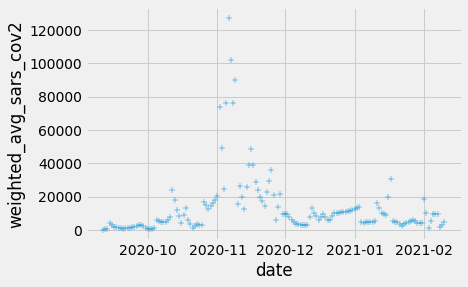

In [112]:
# EDA plots to compare before and after interpolation
# Red = after interpolation

# Raw RNA level over time
sns.scatterplot(data=daily_interpol, x="date", y="weighted_avg_sars_cov2", marker='+')
sns.scatterplot(data=population_sum, x='date', y='catchment_population_ons_mid_2019')
# plt.plot_date(df['date'], df['sars_cov2_gc_l_mean'], c = 'blue') # raw data
plt.title('Raw RNA level Over Time')

# Log RNA level over time
plt.figure()
sns.scatterplot(data=daily_interpol, x="date", y="log_gene", marker='+')
# plt.plot_date(df['date'], np.log10(df['sars_cov2_gc_l_mean']), c = 'blue') # raw data
plt.title('Log RNA level Over Time')

### Relationship between RNA level and R value

In [ ]:
melted_data = pd.melt(daily_interpol[['log_gene', 'SOUTH WEST_LOWER BOUND', 'SOUTH WEST_AVERAGE', 'SOUTH WEST_UPPER BOUND']], id_vars=['log_gene'])

In [ ]:
g = sns.scatterplot(data=melted_data, x='log_gene', y='value', hue='variable', marker='+')
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title('R estimates and Log RNA level')

In [ ]:
# Check number of values under each site
# df3.CIS20CD.value_counts()

# Check number of zero values
# (df == 0).sum()

In [ ]:
daily_interpol.to_csv("Linked Data_South West.csv")